# Build geothermal resource potential suitablity layers for GRIDCERF


The following code was used to build the geothermal resource potential suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  Geothermal Prospector: 500m Estimated Temperature
- **Description from Source**: This data shows an estimate of shallow, low temperature geothermal resources of the United States at 500m.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  9/26/23
- **Citation**
> National Renewable Energy Laboratory, 2022. Geothermal Prospector: 500m Estimated Temperature. NREL, Golden, CO, https://gds-files.nrelcloud.org/archive/geothermal-prospector.zip.

______
- **Title**:  Geothermal Prospector: 1000m Estimated Temperature
- **Description from Source**: This data shows an estimate of shallow, low temperature geothermal resources of the United States at 1000m.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  9/26/23
- **Citation**
> National Renewable Energy Laboratory, 2022. Geothermal Prospector: 1000m Estimated Temperature. NREL, Golden, CO, https://gds-files.nrelcloud.org/archive/geothermal-prospector.zip.
______
- **Title**:  Geothermal Prospector: 1500m Estimated Temperature
- **Description from Source**: This data shows an estimate of shallow, low temperature geothermal resources of the United States at 1500m.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  9/26/23
- **Citation**
> National Renewable Energy Laboratory, 2022. Geothermal Prospector: 1500m Estimated Temperature. NREL, Golden, CO, https://gds-files.nrelcloud.org/archive/geothermal-prospector.zip.
______
- **Title**:  Geothermal Prospector: 2000m Estimated Temperature
- **Description from Source**: This data shows an estimate of shallow, low temperature geothermal resources of the United States at 2000m.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  9/26/23
- **Citation**
> National Renewable Energy Laboratory, 2022. Geothermal Prospector: 2000m Estimated Temperature. NREL, Golden, CO, https://gds-files.nrelcloud.org/archive/geothermal-prospector.zip.
______
- **Title**:  Geothermal Prospector: 2500m Estimated Temperature
- **Description from Source**: This data shows an estimate of shallow, low temperature geothermal resources of the United States at 2500m.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  9/26/23
- **Citation**
> National Renewable Energy Laboratory, 2022. Geothermal Prospector: 2500m Estimated Temperature. NREL, Golden, CO, https://gds-files.nrelcloud.org/archive/geothermal-prospector.zip.
______
- **Title**:  Geothermal Prospector: 3000m Estimated Temperature
- **Description from Source**: This data shows an estimate of shallow, low temperature geothermal resources of the United States at 3000m.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  9/26/23
- **Citation**
> National Renewable Energy Laboratory, 2022. Geothermal Prospector: 3000m Estimated Temperature. NREL, Golden, CO, https://gds-files.nrelcloud.org/archive/geothermal-prospector.zip.

______
______


**Application**: Enhanced Geothermal Systems (EGS) require high temperatures (greater than or equal to 150C, with >200C preferred). The temperatures at various depths are used to create composite suitability layers where all areas that are capable of reaching these temperatures are included. For example, all spatial area, regardless of depth, that is greater than or equal to 150C is included in the 150C resource potential layer. A secondary layer is created for 200C. See https://www.energy.gov/sites/default/files/2023-01/enhanced-geothermal-shot-faq_012023.pdf for more information on EGS.


### 1.3 Import modules


In [10]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [6]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'geothermal_resource_potential' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source data
depth_500_shpfile = os.path.join(source_dir, '500m_Estimated_Temperature',  "500m_Estimated_Temperature.shp")
depth_1000_shpfile = os.path.join(source_dir, '1000m_Estimated_Temperature',  "1000m_Estimated_Temperature.shp")
depth_1500_shpfile = os.path.join(source_dir, '1500m_Estimated_Temperature',  "1500m_Estimated_Temperature.shp")
depth_2000_shpfile = os.path.join(source_dir, '2000m_Estimated_Temperature',  "2000m_Estimated_Temperature.shp")
depth_2500_shpfile = os.path.join(source_dir, '2500m_Estimated_Temperature',  "2500m_Estimated_Temperature.shp")
depth_3000_shpfile = os.path.join(source_dir, '3000m_Estimated_Temperature',  "3000m_Estimated_Temperature.shp")

# output rasters
output_150c_file = os.path.join(technology_specific_dir, "gridcerf_nrel_geothermal_temp_potential_greaterthan150c.tif")
output_200c_file = os.path.join(technology_specific_dir, "gridcerf_nrel_geothermal_temp_potential_greaterthan200c.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'

## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [27]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            # swap suitability value
            burned = np.where(burned == 1, 0, 1)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [5]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

In [7]:
# read in shapefiles and project to our GRIDCERF projection
gdf_500 = gpd.read_file(depth_500_shpfile).to_crs(crs=crs)
gdf_1000 = gpd.read_file(depth_1000_shpfile).to_crs(crs=crs)
gdf_1500 = gpd.read_file(depth_1500_shpfile).to_crs(crs=crs)
gdf_2000 = gpd.read_file(depth_2000_shpfile).to_crs(crs=crs)
gdf_2500 = gpd.read_file(depth_2500_shpfile).to_crs(crs=crs)
gdf_3000 = gpd.read_file(depth_3000_shpfile).to_crs(crs=crs)

In [30]:
combined_df = pd.concat([gdf_500,gdf_1000,gdf_1500,gdf_2000,gdf_2500,gdf_3000])
gdf = gpd.GeoDataFrame(combined_df, geometry=combined_df['geometry'])

In [31]:
# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

#### 4.2.1 150C Temperature or Greater

<Axes: >

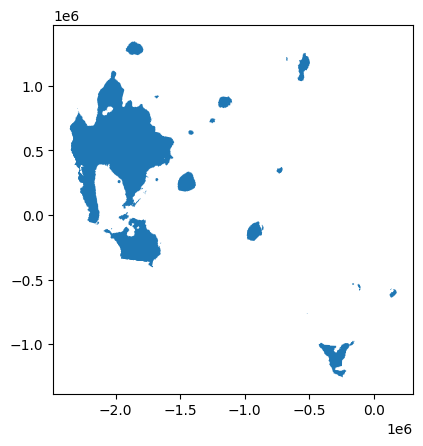

In [32]:
gdf_150 = gdf[gdf['ESTIMATED '] >= 150]
gdf_150.plot()

In [33]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=gdf_150, 
                 value_field="value",
                 output_raster=output_150c_file)

#### 4.2.1 200C Temperature or Greater

<Axes: >

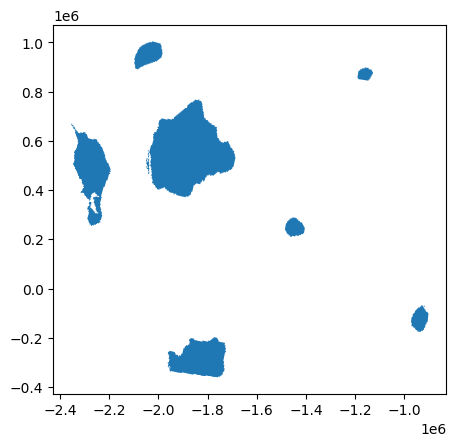

In [34]:
gdf_200 = gdf[gdf['ESTIMATED '] >= 200]
gdf_200.plot()

In [35]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=gdf_200, 
                 value_field="value",
                 output_raster=output_200c_file)